In [1]:
#Run this once
%load_ext autoreload
%autoreload 2
import os, sys
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
project_dir = "/codespace/braintypicality"
sys.path.append(project_dir)

In [2]:
import skimage
import glob
import math
import torch
import ants
import monai
import numpy as np
import seaborn as sns
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

from matplotlib import ticker
import matplotlib as mpl
import matplotlib.colors as mcolors

2023-09-05 01:19:24.347607: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-05 01:19:24.349923: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-05 01:19:24.384434: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



In [3]:
import datasets
import FrEIA.framework as Ff
import FrEIA.modules as Fm
from functools import partial
from einops import rearrange
from models.flows import ScoreAttentionBlock, PatchFlow, gaussian_logprob

In [4]:
from scipy.stats import percentileofscore
from numba import jit
from utils import get_percentile_tensor

In [5]:
import sde_lib
from models import ncsnpp3d
from models import utils as mutils
from models.ema import ExponentialMovingAverage
from utils import restore_checkpoint, restore_pretrained_weights, save_checkpoint
from configs.flows import biggan_default as configs
config = configs.get_config()
config.msma.denoise=False
config.msma.schedule = "geometric"
config.model.learnable_embedding=True
workdir = "/ASD/ahsan_projects/braintypicality/workdir/cuda_opt/learnable"

### Load the data

In [6]:
config.data.ood_ds = "lesion_load_20"
config.data.cache_rate = 0.0
config.eval.batch_size = 16
config.data

as_tfds: false
cache_rate: 0.0
centered: false
colab_path: /content/drive/MyDrive/ML_Datasets/ABCD/processed/
colab_splits_path: /content/drive/MyDrive/Developer/braintypicality/dataset/
colab_tumor_path: /content/drive/MyDrive/ML_Datasets/ABCD/tumor/
dataset: BRAIN
dir_path: /DATA/Users/amahmood/braintyp/processed_v2/
gen_ood: false
image_size: !!python/tuple
- 96
- 112
- 80
num_channels: 2
ood_ds: lesion_load_20
select_channel: -1
spacing_pix_dim: 2.0
splits_path: /home/braintypicality/dataset/
tumor_dir_path: /DATA/Users/amahmood/tumor/
uniform_dequantization: false

In [7]:
%%time
config.device = torch.device("cpu")
inlier_ds, ood_ds, _ = datasets.get_dataset(
    config, evaluation=True, ood_eval=True,
)

x_inlier = torch.cat([x["image"] for x in inlier_ds])

Collected samples: 86 from /ASD/ahsan_projects/lesion_samples/lesion_load_20
CPU times: user 342 ms, sys: 484 ms, total: 827 ms
Wall time: 10.1 s


In [8]:
%%time
x_ood = []
x_ood_labels = []
for x in ood_ds:
    x_ood.append(x["image"])
    x_ood_labels.append(x["label"])

x_ood = torch.cat(x_ood)
x_ood_labels = torch.cat(x_ood_labels)

CPU times: user 449 ms, sys: 604 ms, total: 1.05 s
Wall time: 12.6 s


In [9]:
len(x_ood_labels)

86

In [10]:
from utils import get_flow_rundir
config.flow.patch_size = 3
config.flow.gmm_components = -1
config.flow.num_blocks = 20
config.flow.patch_batch_size = 128
config.training.batch_size = 64
config.flow.patches_per_train_step = 256
config.flow.training_kimg = 100

# flow_path = f"{workdir}/flow/psz{config.flow.patch_size}-nb{config.flow.num_blocks}-gmm{config.flow.gmm_components}-lr0.0003-bs{16}-pbs{config.flow.patch_batch_size}-kimg50/"

flow_path = '/ASD/ahsan_projects/braintypicality/workdir/cuda_opt/learnable/flow-masked/psz3-nb20-gmm-1-lr0.0003-bs64-np256-kimg100'

In [11]:
%ls -ailh $flow_path

total 555M
77331792912 drwxr-xr-x. 3 amahmood root 4.0K Sep  4 15:33 ./
73032602974 drwxr-xr-x. 3 amahmood root   64 Aug 31 20:05 ../
81628188038 drwxr-xr-x. 2 amahmood root   10 Aug 31 20:25 .ipynb_checkpoints/
77341052540 -rw-r--r--. 1 amahmood root 487M Sep  4 15:34 anomaly_scores.npz
77331792917 -rw-r--r--. 1 amahmood root  35M Aug 31 20:29 checkpoint-old.pth
77338565775 -rw-r--r--. 1 amahmood root  35M Sep  2 14:26 checkpoint.pth
77331792916 -rw-r--r--. 1 amahmood root 171K Sep  2 14:26 events.out.tfevents.1693513574.11d10908c9f3.1697258.0
77331792915 -rw-r--r--. 1 amahmood root 5.3K Sep  2 14:12 stdout.txt


In [12]:
data = np.load(f"{flow_path}/anomaly_scores.npz", allow_pickle=True)
x_inlier_scores = data["inliers"]
x_ood_scores = data['lesions']
print(data.files)

['inliers', 'lesions']


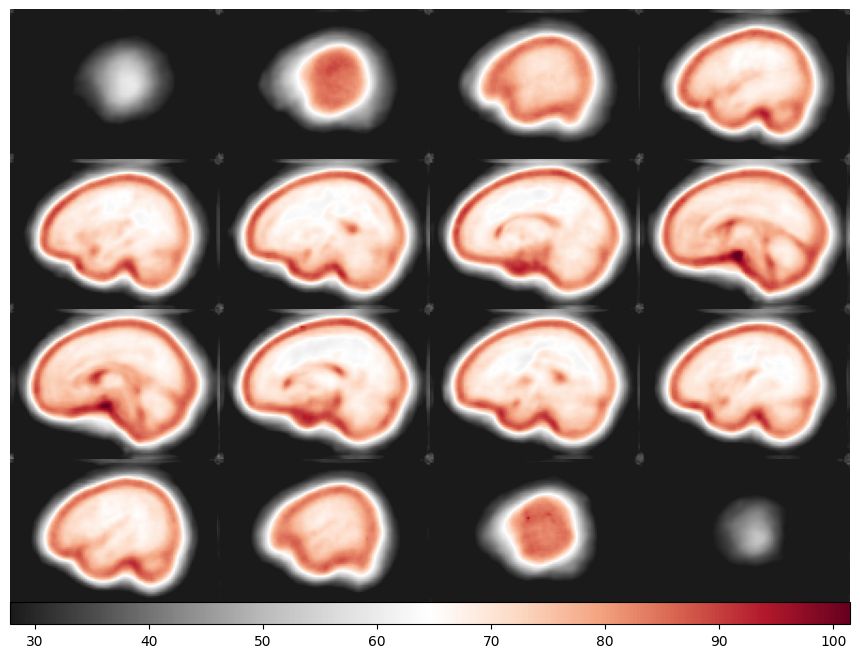

In [13]:
x_img = ants.from_numpy(x_inlier_scores.mean(0))

ants.plot(x_img + 100, overlay=None, nslices=16, cmap="RdGy_r",
          cbar=True, cbar_vertical=False, scale=(0.5, 0.9999),
#           black_bg=False, bg_thresh_quant=0.0001,  bg_val_quant=0.0001
)

In [14]:
%%time
inlier_percentiles = get_percentile_tensor(x_inlier_scores[:1], x_inlier_scores, kernel_sz=3)

CPU times: user 8.4 s, sys: 104 ms, total: 8.51 s
Wall time: 8.47 s


In [15]:
%%time
ood_percentiles = get_percentile_tensor(x_ood_scores[:3], x_inlier_scores,  kernel_sz=3)
ood_percentiles.shape

CPU times: user 10.2 s, sys: 150 ms, total: 10.4 s
Wall time: 10.2 s


(3, 96, 112, 80)

### Unsmooothed, unmasked Percentiles

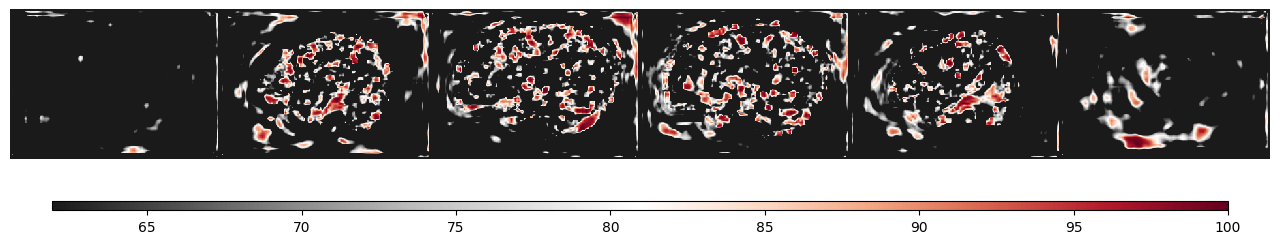

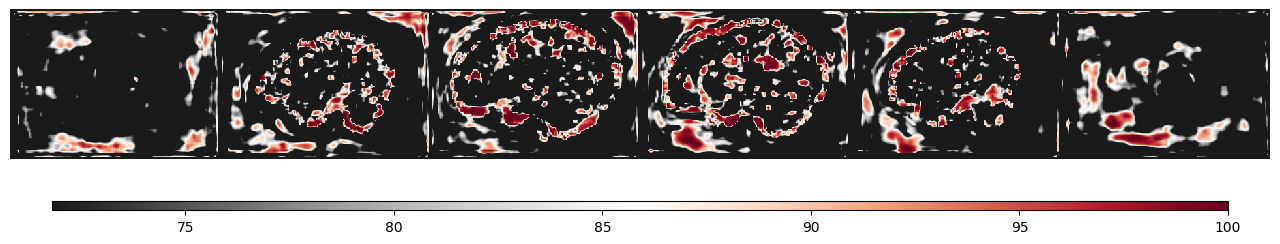

In [16]:
x_ood_img = ants.from_numpy(inlier_percentiles[0])
ants.plot(x_ood_img, overlay=None, nslices=6, cmap="RdGy_r", cbar=True, cbar_vertical=False, 
          scale=(0.8, 0.9999),
)
x_ood_img = ants.from_numpy(ood_percentiles[0])
ants.plot(x_ood_img, overlay=None, nslices=6, cmap="RdGy_r", cbar=True, cbar_vertical=False, 
          scale=(0.7, 0.9999),
)

## Computing brain masks

In [17]:
%%time
inlier_brain_masks = (x_inlier != -1.0).sum(dim=1).bool()
ood_brain_masks = (x_ood != -1.0).sum(dim=1).bool()
# brain_masked_scores = x_inlier_scores.copy()
# brain_masked_scores[inlier_brain_masks] = x_inlier_scores.min()
# brain_masked_scores = brain_masked_scores * inlier_brain_masks + x_inlier_scores.min() * (~inlier_brain_masks)

CPU times: user 2.28 s, sys: 1.25 s, total: 3.53 s
Wall time: 513 ms


In [18]:
def erode_brain_masks(masks):
    eroded_masks = np.zeros_like(masks)
    for i, m in enumerate(masks):
        m = ants.from_numpy(m.float().numpy())
        m = ants.morphology(m, operation='erode', radius=2, mtype='binary', shape="ball", radius_is_parametric=True)
        eroded_masks[i] = m.numpy()
    return eroded_masks

In [19]:
%%time
eroded_inlier_brain_masks = erode_brain_masks(inlier_brain_masks)
eroded_ood_brain_masks = erode_brain_masks(ood_brain_masks)

CPU times: user 31.1 s, sys: 201 ms, total: 31.3 s
Wall time: 12.4 s


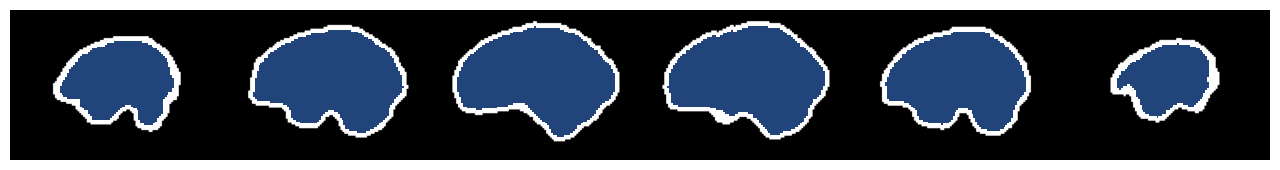

In [20]:
mask = ants.from_numpy((ood_brain_masks[0]).float().numpy())
eroded_mask = ants.from_numpy(eroded_ood_brain_masks[0].astype(float))
mask.plot(overlay=eroded_mask, overlay_cmap="Blues", nslices=6)

In [21]:
%%time
brain_masked_scores = x_inlier_scores.copy()
brain_masked_scores = brain_masked_scores * inlier_brain_masks + x_inlier_scores.min() * (~inlier_brain_masks)

CPU times: user 349 ms, sys: 177 ms, total: 525 ms
Wall time: 344 ms


In [22]:
%%time
# brain_masks = (x_ood[:3] == -1.0).sum(dim=1).bool()
brain_masked_ood_scores = x_ood_scores.copy()
brain_masked_ood_scores = brain_masked_ood_scores * ood_brain_masks + x_inlier_scores.min() * (~ood_brain_masks)

CPU times: user 309 ms, sys: 224 ms, total: 534 ms
Wall time: 380 ms


#### Getting prediciton labels and masking them

In [23]:
pred_labels = x_ood_labels.sum(1).cpu().numpy() > 0
pred_labels_masked = pred_labels * eroded_ood_brain_masks

In [24]:
eroded_masked_scores =  x_inlier_scores.copy() * eroded_inlier_brain_masks + x_inlier_scores.min() * (~eroded_inlier_brain_masks)
eroded_masked_ood_scores =  x_ood_scores.copy() * eroded_ood_brain_masks + x_inlier_scores.min() * (~eroded_ood_brain_masks)

### Brain mask rim

In [25]:
brain_mask_rims = (ood_brain_masks * (~eroded_ood_brain_masks)).astype(float)

In [26]:
x_ood_img_orig = ants.from_numpy(x_ood[0,1].numpy() + 1) / 2
x_img_orig = ants.from_numpy(x_inlier[0,1].numpy() + 1) / 2

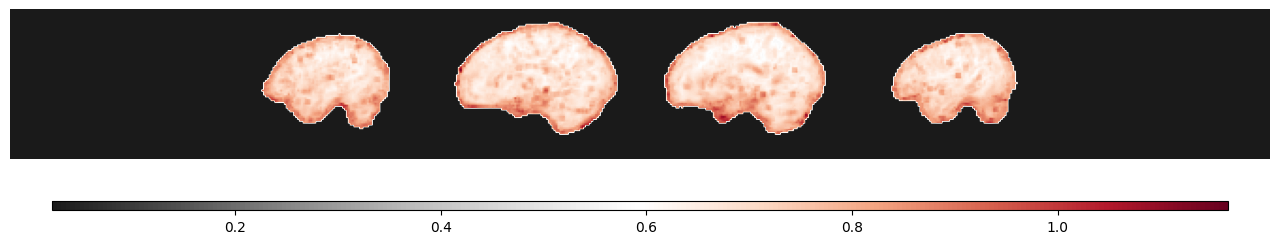

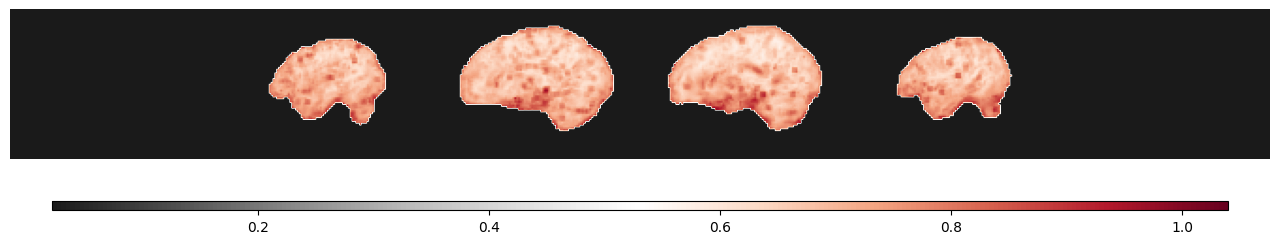

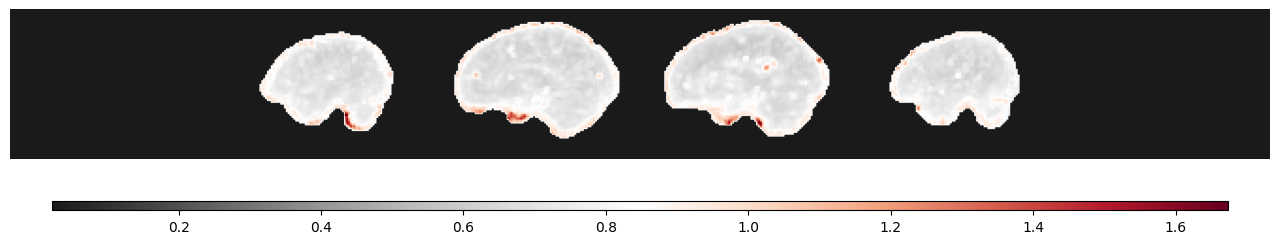

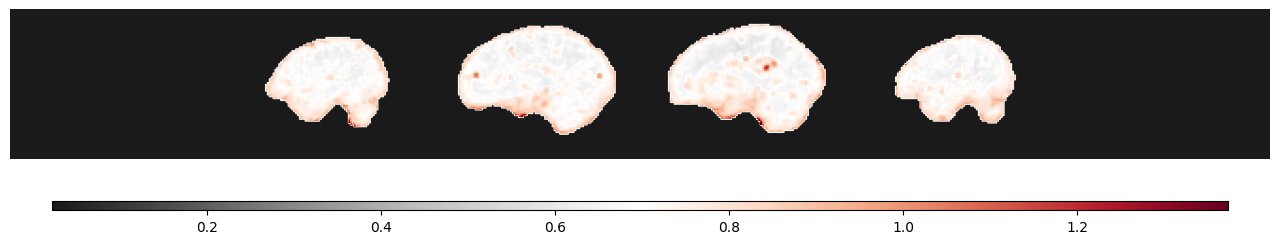

In [27]:
x_img_masked = ants.from_numpy(brain_masked_scores[0] / 100) + 1
ants.plot(x_img_masked , overlay=None, nslices=6, cmap="RdGy_r",
          cbar=True, cbar_vertical=False, scale=(0.1, 0.9999),
)
x_img_masked_eroded = ants.from_numpy(eroded_masked_scores[0] / 100) + 1
ants.plot(x_img_masked_eroded , overlay=None, nslices=6, cmap="RdGy_r",
          cbar=True, cbar_vertical=False, scale=(0.1, 0.9999),
)
x_ood_img_masked = ants.from_numpy(brain_masked_ood_scores[0] / 100) + 1
ants.plot(x_ood_img_masked, overlay=None, nslices=6, cmap="RdGy_r",
          cbar=True, cbar_vertical=False, scale=(0.1, 0.9999),
)
x_ood_img_masked_eroded = ants.from_numpy(eroded_masked_ood_scores[0] / 100) + 1
ants.plot(x_ood_img_masked_eroded, overlay=None, nslices=6, cmap="RdGy_r",
          cbar=True, cbar_vertical=False, scale=(0.1, 0.9999),
)

In [28]:
# plot_normalized_slices(x_ood_img_orig, overlay=x_ood_img_masked, overlay_alpha=0.4, overlay_cmap="Reds_r", norm=mpl.colors.PowerNorm(gamma=3))

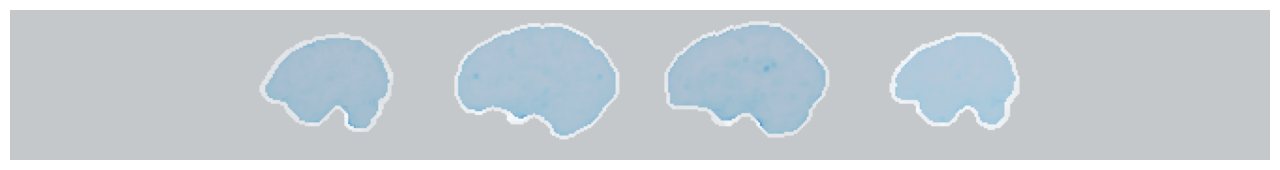

In [29]:
x_ood_img_masked.plot(overlay=x_ood_img_masked_eroded, overlay_alpha=0.8, overlay_cmap="Blues", nslices=6)

In [30]:
%%time
import skimage.filters as skf

# "0-th" channel allows us to do batched filtering
sigma = 0.2
# smoothed_brain_masked_scores = skf.gaussian(brain_masked_scores, sigma=sigma, channel_axis=0)
# smoothed_brain_masked_ood_scores = skf.gaussian(brain_masked_ood_scores, sigma=sigma, channel_axis=0)

smoothed_scores = skf.gaussian(x_inlier_scores, sigma=sigma, channel_axis=0)
smoothed_ood_scores = skf.gaussian(x_ood_scores, sigma=sigma, channel_axis=0)

# smoothed_brain_masked_ood_scores = skf.media(x_ood_scores, sigma=sigma, channel_axis=0)
# smoothed_brain_masked_ood_scores = skf.median(x_ood_scores, channel_axis=0)
smoothed_brain_masked_ood_scores =   skf.gaussian(brain_masked_ood_scores, sigma=sigma, channel_axis=0)

CPU times: user 2.18 s, sys: 177 ms, total: 2.36 s
Wall time: 2.36 s


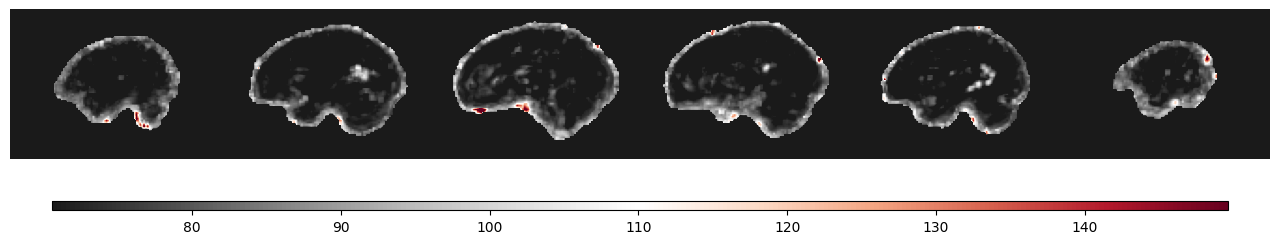

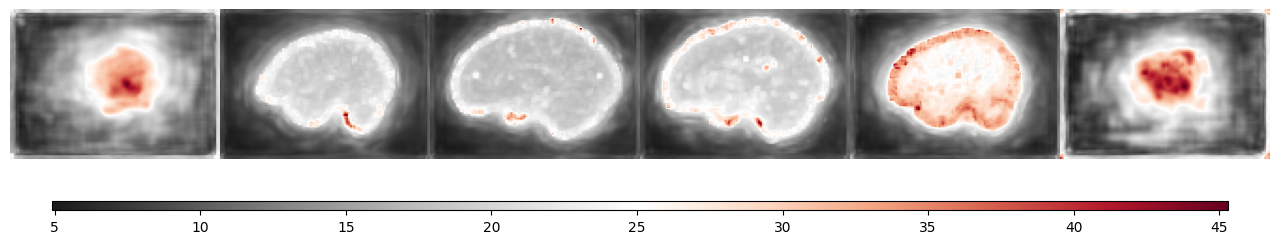

In [31]:
x_img_masked = ants.from_numpy(smoothed_brain_masked_ood_scores[0])
ants.plot(x_img_masked  - x_img_masked.min(), overlay=None, nslices=6, cmap="RdGy_r",
          cbar=True, cbar_vertical=False, scale=(0.5, 0.999),
)
ants.from_numpy(smoothed_ood_scores[0]-x_inlier_scores.min()).plot(nslices=6, cbar=True, cbar_vertical=False, cmap="RdGy_r")

In [32]:
%%time
masked_ood_percentiles = get_percentile_tensor(brain_masked_ood_scores[:3],
                                               brain_masked_scores,
                                               kernel_sz=2)
masked_ood_percentiles.shape

CPU times: user 10.2 s, sys: 102 ms, total: 10.3 s
Wall time: 10.2 s


(3, 96, 112, 80)

In [33]:
x_ood_img = ants.from_numpy(x_ood[0,1].cpu().numpy()+1) / 2
x_ood_percentile = ants.from_numpy(masked_ood_percentiles[0]/100)
x_ref_img = ants.from_numpy(pred_labels_masked[0].astype(float))

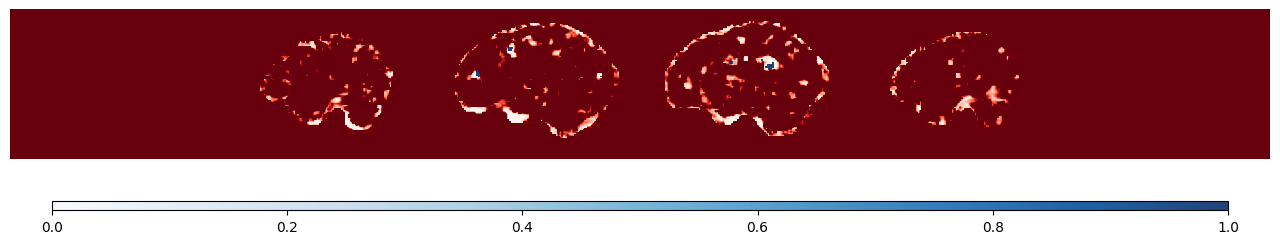

In [34]:
ants.plot(x_ood_percentile, overlay=x_ref_img, nslices=6, cmap="Reds_r",
          cbar=True, cbar_vertical=False, overlay_cmap="Blues", overlay_alpha=0.9,
          scale=(0.95, 0.9999),
)

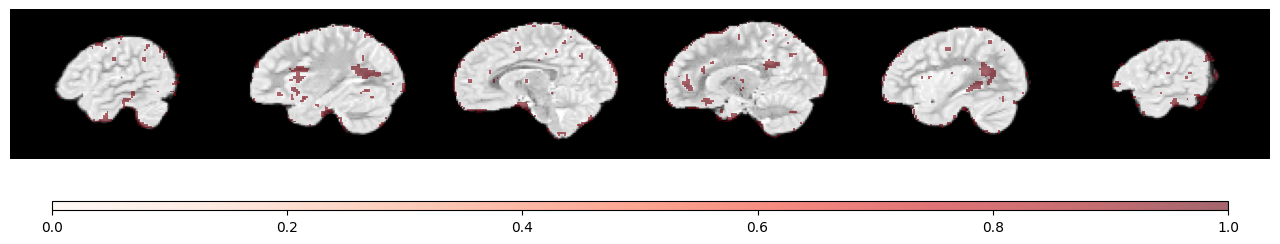

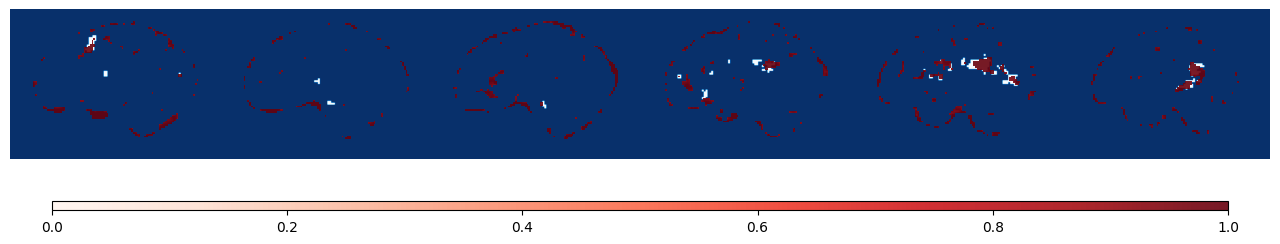

In [35]:
ants.plot(x_ood_img, overlay=x_ood_percentile * (x_ood_percentile > 0.9), nslices=6, overlay_cmap="Reds", cbar=True, cbar_vertical=False, 
          scale=(0.01, 1.0), overlay_alpha=0.6,
)
ants.plot(x_ref_img, overlay=x_ood_percentile * (x_ood_percentile > 0.9), nslices=6, overlay_cmap="Reds", 
          cbar=True, cbar_vertical=False, overlay_alpha=0.9, cmap="Blues_r"
)

## Steps
- Use *original* brain masks to compute connected components
- Compute eroded masks
- Subtract from orig to get brain mask rim
- Remove components that touch the *mask rim*

### Hausdorff Distances

In [36]:
def remove_small_components(ccp, size=2, verbose=True):
    filtered_ccp = ccp.copy()
    n_components = len(np.unique(ccp)) - 1
    new_components = n_components
    for i in range(1, n_components+1):
        lesion_comp_mask = ccp == i
        if lesion_comp_mask.sum()  > 0 and lesion_comp_mask.sum() < size:
            filtered_ccp[ccp == i] = 0
            new_components -= 1
    if verbose:
        print(f"Number of components removed: {n_components - new_components} -> Remaining: {new_components}")
    
    return filtered_ccp, new_components

def post_processing(seg_mask, brain_mask_rim=None, sigma=0, dilate=False):
    
    # "Erosion" - Removing single voxel components
    seg_ccp, seg_components = skimage.measure.label(seg_mask, background=0, return_num=True, connectivity=1)
    seg_ccp, num_seg_components_post = remove_small_components(seg_ccp, size=2, verbose=False)

    # Denoising - Removing small components
    if sigma > 0.0:
        smoothed_seg_mask = skf.gaussian(seg_ccp > 0, sigma=sigma) > 0
        seg_ccp, seg_components = skimage.measure.label(smoothed_seg_mask, background=0, return_num=True, connectivity=1)

    # Ignoring brain border
    border_components = np.unique(seg_ccp[brain_mask_rim.astype(bool)])

    for i in border_components:
        if i == 0: continue
        seg_ccp[seg_ccp == i] = 0
        
    post_proc_mask = seg_ccp > 0
    
    # End result is similar to morphological "opening" when combined with "erosion" above
    if dilate:
        post_proc_mask = skimage.morphology.dilation(post_proc_mask, footprint=ball(1))
    
    return post_proc_mask

In [37]:
ref_mask = torch.from_numpy(pred_labels_masked[0])
ref_mask.shape

torch.Size([96, 112, 80])

In [38]:
brain_mask_rims.shape

(86, 96, 112, 80)

In [ ]:
%%time
from monai.metrics import compute_hausdorff_distance, compute_average_surface_distance
from scipy.stats import percentileofscore
from skimage.morphology import cube, disk, ball

seg_thresholds = []

for sample_idx in range(len(x_ood_scores)):

    skull_mask = brain_mask_rims[sample_idx]
    ref_mask = post_processing(pred_labels[sample_idx], skull_mask)
    y_ref = torch.from_numpy(ref_mask)
    y_ref = torch.nn.functional.one_hot(y_ref.long(), 2).unsqueeze(0).permute(0,4,1,2,3)

    # seg = smoothed_brain_masked_ood_scores[0]
    seg = brain_masked_ood_scores[sample_idx]

    # brain eriosion here to remove edge labels

    threshes = np.linspace(np.quantile(seg, 0.9), np.quantile(seg, 0.9999), 1000)
    dists = []
    for t in threshes:
        seg_mask = (seg > t)
        seg_mask = post_processing(seg_mask, brain_mask_rim=skull_mask, dilate=True)
        y_pred = torch.from_numpy(seg_mask).float().unsqueeze(0)
        y_pred = torch.nn.functional.one_hot(y_pred.long(), 2).permute(0,4,1,2,3)
        d = compute_average_surface_distance(y_ref, y_pred, symmetric=False).item()
        dists.append(d)

    dists = np.asarray(dists)
    best_thresh = threshes[dists.argmin()]
#     thresh_percentile = percentileofscore(brain_masked_scores.mean(0).ravel(), best_thresh)
#     print(f"Minimum dist: {dists.min()} at thresh={thresh_percentile:.2f} percentile")
    seg_thresholds.append(best_thresh)

In [45]:
len(seg_thresholds)

86

In [47]:
%%time
skull_mask = brain_mask_rims[sample_idx]
seg = brain_masked_ood_scores[sample_idx]
best_thresh = seg_thresholds[sample_idx]
ref_mask = post_processing(pred_labels[sample_idx], skull_mask)
best_seg_mask = post_processing(seg > best_thresh, skull_mask, dilate=True)
y_pred = torch.from_numpy(best_seg_mask).float().unsqueeze(0)
y_pred = torch.nn.functional.one_hot(y_pred.long(), 2).permute(0,4,1,2,3)
hauss_ref_to_pred = compute_hausdorff_distance(y_ref, y_pred, include_background=False, directed=True, percentile=99)
hauss_ref_to_pred

CPU times: user 495 ms, sys: 1 ms, total: 496 ms
Wall time: 359 ms


tensor([[6.1644]])

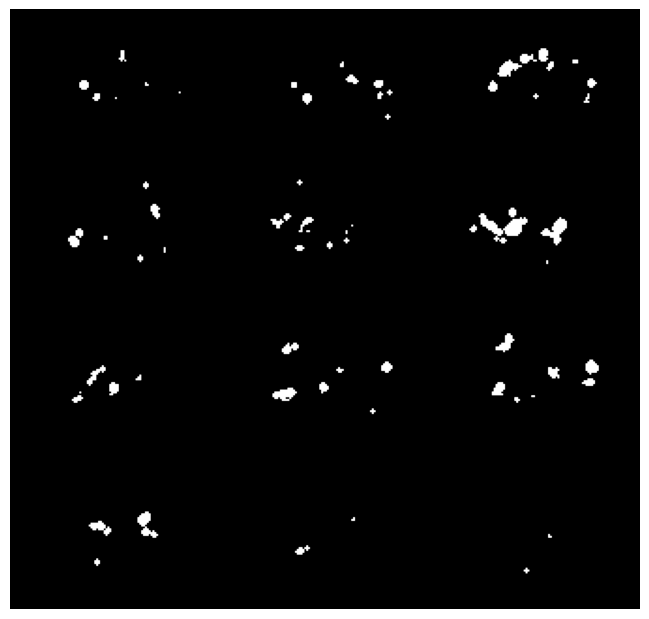

In [48]:
# smoothed_seg_mask = skf.gaussian(best_seg_mask, sigma=0.01) > 0
ants.from_numpy(best_seg_mask.astype(float)).plot()

### Connected Components analysis

In [49]:

ball(1)

array([[[0, 0, 0],
        [0, 1, 0],
        [0, 0, 0]],

       [[0, 1, 0],
        [1, 1, 1],
        [0, 1, 0]],

       [[0, 0, 0],
        [0, 1, 0],
        [0, 0, 0]]], dtype=uint8)

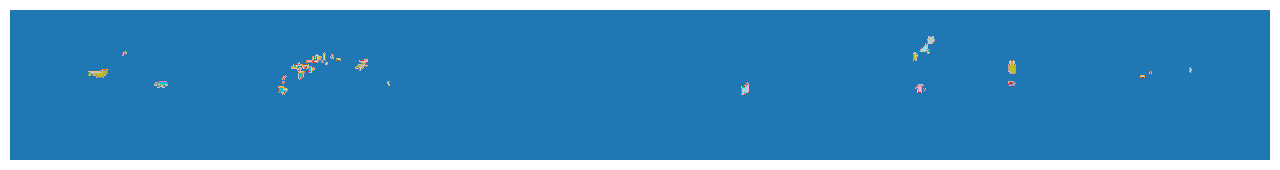

12

In [50]:
ref_ccp, ref_components = skimage.measure.label(ref_mask, background=0, return_num=True, connectivity=3)
ref_ccp = ref_ccp.astype(float)
ccp_img = ants.from_numpy(ref_ccp)
ants.plot(ccp_img, cmap="tab20", overlay_alpha=1.0, nslices=6, resample=False)
ref_components

In [51]:
# ref_ccp, num_ref_components_post = remove_small_components(ref_ccp, size=2)
# ccp_img_post = ants.from_numpy(ref_ccp)
# ccp_img_post.plot(cmap="tab20", nslices=6)

Number of components removed: 0 -> Remaining: 45


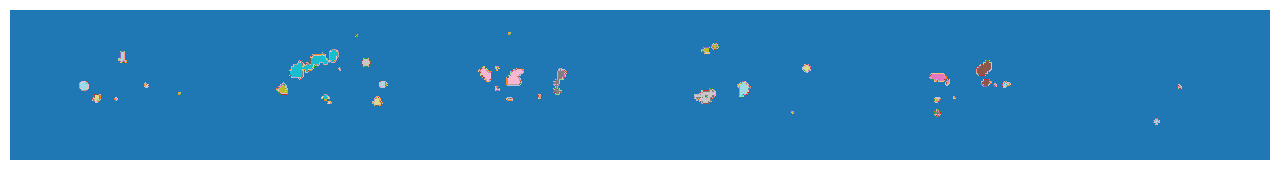

45

In [52]:
seg_ccp, seg_components = skimage.measure.label(best_seg_mask, background=0, return_num=True, connectivity=3)
cleaned_seg_ccp, num_seg_components_post = remove_small_components(seg_ccp, size=2)
seg_ccp_img_post = ants.from_numpy(cleaned_seg_ccp.astype(float))
seg_ccp_img_post.plot(cmap="tab20", nslices=6)
num_seg_components_post

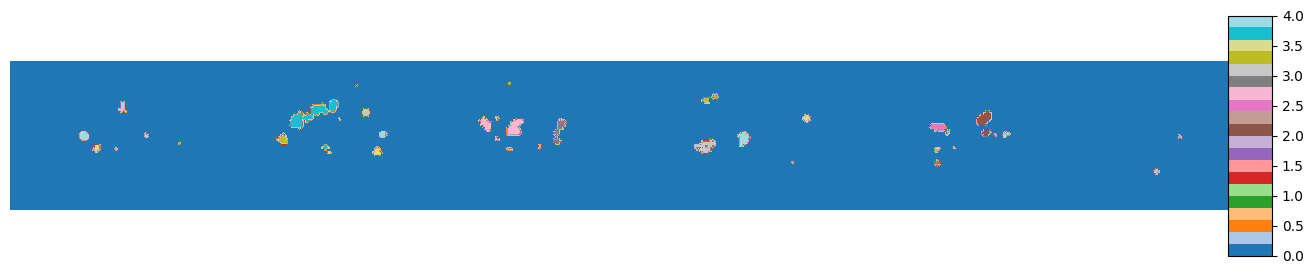

CPU times: user 253 ms, sys: 117 ms, total: 370 ms
Wall time: 218 ms


33

In [53]:
%%time
dilated_seg = skimage.morphology.dilation(best_seg_mask, footprint=ball(1))
opened_seg_ccp, num_seg_components_post = skimage.measure.label(dilated_seg, background=0, return_num=True, connectivity=3)
ants.from_numpy(cleaned_seg_ccp.astype(float)).plot(cmap="tab20", nslices=6, cbar=True)
num_seg_components_post

In [54]:
def segmentation_metrics(reference_ccp, segmentation_ccp):
    FP = 0
    TP = 0
    FN = 0

    GT = len(np.unique(reference_ccp.ravel()))
    S = len(np.unique(segmentation_ccp.ravel()))

    # Using reference components
    for i in range(1, GT + 1):
        lesion_comp_mask = reference_ccp == i
        seg_overlap = segmentation_ccp[lesion_comp_mask]
        if np.unique(seg_overlap).sum() > 0:
            TP += 1
        else:
            # No matching segementation component
            FN += 1

    # Iterating over segemntation components
    for i in range(1, S + 1):
        lesion_comp_mask = segmentation_ccp == i
        seg_overlap = reference_ccp[lesion_comp_mask]

        # If no matching reference component
        if np.unique(seg_overlap).sum() == 0:
            FP += 1

    metrics = {
        "TP": TP,
        "FP": FP,
        "FN": FN,
        "ground_truth_components": GT,
        "segmentation_components": S,
    }

    return metrics

In [55]:
perf_dict = segmentation_metrics(ref_ccp, opened_seg_ccp)
y_pred = torch.from_numpy(opened_seg_ccp > 0).float().unsqueeze(0)
y_pred = torch.nn.functional.one_hot(y_pred.long(), 2).permute(0,4,1,2,3)
hauss_ref_to_pred = compute_hausdorff_distance(y_ref, y_pred, include_background=False, directed=True, percentile=99)
perf_dict["hausdorff"] = hauss_ref_to_pred.item()

In [56]:
metrics_df = pd.DataFrame(columns=["TP", "FP", "FN", "ground_truth_components", "segmentation_components"])
metrics_df

,TP,FP,FN,ground_truth_components,segmentation_components


In [57]:
# FP = ref_ccp == 0 and number of comps that match

In [58]:
%%time
for sample_idx, thresh in enumerate(seg_thresholds):
    skull_mask = brain_mask_rims[sample_idx]
    score = brain_masked_ood_scores[sample_idx]
    best_thresh = seg_thresholds[sample_idx]
    ref_mask = post_processing(pred_labels[sample_idx], skull_mask)
    
    ref_ccp, ref_components = skimage.measure.label(ref_mask, background=0, return_num=True, connectivity=3)
    best_seg_mask = post_processing(seg > best_thresh, skull_mask, dilate=True)
    
    y_pred = torch.from_numpy(best_seg_mask).float().unsqueeze(0)
    y_pred = torch.nn.functional.one_hot(y_pred.long(), 2).permute(0,4,1,2,3)
    hauss_ref_to_pred = compute_hausdorff_distance(y_ref, y_pred, include_background=False, directed=True, percentile=99)
    
    perf_dict = segmentation_metrics(ref_ccp, best_seg_mask)
    perf_dict["hausdorff"] = hauss_ref_to_pred.item()
    metrics_df.loc[sample_idx] = perf_dict

CPU times: user 56.8 s, sys: 207 ms, total: 57 s
Wall time: 41.8 s


In [59]:
metrics_df["TPR"] = metrics_df.TP / metrics_df.ground_truth_components
metrics_df["PPV"] = metrics_df.TP / (metrics_df.TP + metrics_df.FP)
metrics_df

,TP,FP,FN,ground_truth_components,segmentation_components,TPR,PPV
0,7,1,9,16,2,0.437500,0.875000
1,4,1,5,9,2,0.444444,0.800000
2,4,1,4,8,2,0.500000,0.800000
3,0,2,1,1,2,0.000000,0.000000
4,8,1,9,17,2,0.470588,0.888889
...,...,...,...,...,...,...,...
81,1,1,5,6,2,0.166667,0.500000
82,6,1,13,19,2,0.315789,0.857143
83,5,1,5,10,2,0.500000,0.833333
84,5,1,4,9,2,0.555556,0.833333


In [60]:
metrics_df.describe()

,TP,FP,FN,ground_truth_components,segmentation_components,TPR,PPV
count,86.000000,86.000000,86.000000,86.000000,86.0,86.000000,86.000000
mean,3.860465,1.139535,9.965116,13.825581,2.0,0.292206,0.666224
std,2.782985,0.348536,8.794982,9.206381,0.0,0.188718,0.288216
min,0.000000,1.000000,1.000000,1.000000,2.0,0.000000,0.000000
25%,2.000000,1.000000,5.000000,8.000000,2.0,0.177807,0.666667
50%,3.000000,1.000000,8.000000,12.000000,2.0,0.318182,0.750000
75%,6.000000,1.000000,12.000000,17.000000,2.0,0.408824,0.857143
max,12.000000,2.000000,47.000000,50.000000,2.0,0.923077,0.923077


In [61]:
metrics_df.std() / np.sqrt(len(metrics_df))

TP                         0.300097
FP                         0.037584
FN                         0.948387
ground_truth_components    0.992750
segmentation_components    0.000000
TPR                        0.020350
PPV                        0.031079
dtype: float64